In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [2]:
random_seed = 2147483647

words = open('names.txt', 'r').read().splitlines()

random.Random(random_seed).shuffle(words)

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}


In [3]:
context_size = 4

def build_training_data(words):
    """
    Return X, Y tuple of training data and labels given words.

    X will contain one row for each example. Each example will contain `context_size`
    elements representing character indices.

    Y will contain a character index label for each example.
    """

    xs = []
    ys = []
    for word in words:
        context = [0] * context_size
        for ch in word:
            ich = stoi[ch]
            xs.append(context)
            ys.append(ich)
            context = context[1:] + [ich]
        xs.append(context)
        ys.append(0)
    assert len(xs) == len(ys)
    X = torch.tensor(xs)
    Y = torch.tensor(ys)
    return X, Y

train_cutoff = int(0.8 * len(words))
dev_cutoff = int(0.9 * len(words))

X_train, Y_train = build_training_data(words[:train_cutoff])
X_dev, Y_dev = build_training_data(words[train_cutoff:dev_cutoff])
X_test, Y_test = build_training_data(words[dev_cutoff:])

print("training examples:", len(Y_train))
print("dev examples:", len(Y_dev))
print("test examples:", len(Y_test))



training examples: 182546
dev examples: 22840
test examples: 22760


In [4]:

# Number of characters in our alphabet (the very first one is the terminator character).
vocab_size = 27

# Number of dimensions in vector space that we map each character to.
embedding_dims = 3

# The length of a context as a "flattened" array of each of its character's embeddings.
embedded_context_dims = context_size * embedding_dims

g = torch.Generator().manual_seed(random_seed)

# Matrix containing a "lookup table" from character indices to their embeddings in the vector space.
C = torch.randn((vocab_size, embedding_dims), dtype=torch.float, generator=g)

# Number of neurons in the hidden layer
w1_neurons = 200

# Hidden tanh layer
W1 = torch.randn((embedded_context_dims, w1_neurons), dtype=torch.float, generator=g)

b1 = torch.randn(w1_neurons, dtype=torch.float, generator=g)

# Final softmax layer, scaled by 0.1 to make the initial weights be as similar to
# each other as possible to start, thus ultimately giving each character an equal
# probability, which results in a much better initial loss (described in beginning
# of lecture 4).
W2 = torch.randn((w1_neurons, vocab_size), dtype=torch.float, generator=g) * 0.1

# Initialize softmax biases to 0 so every character has equal probability (see above).
b2 = torch.randn(vocab_size, dtype=torch.float, generator=g) * 0

params = [C, W1, b1, W2, b2]

for param in params:
    param.requires_grad = True

print("Total parameters:", sum([param.numel() for param in params]))


Total parameters: 8108


In [5]:
def forward(X):
    num_examples = X.shape[0]

    # Each row is an example consisting of a "flattened" tensor of each character in the context.
    CX = C[X].view(num_examples, embedded_context_dims)

    # Make sure the very first example's first context item is the terminator character.
    # Commenting this out b/c we want this code to be used for more than just training!
    #terminator = C[0]
    #assert CX[0][:embedding_dims].tolist() == terminator.tolist()

    CXW1 = torch.tanh(CX @ W1 + b1)

    assert list(CXW1.shape) == [num_examples, w1_neurons]

    logits = CXW1 @ W2 + b2

    assert list(logits.shape) == [num_examples, vocab_size]

    # Use torch's softmax here to improve efficiency.
    probs = F.softmax(logits, dim=1)

    # Inefficient (but more transparent) code:
    #fake_counts = logits.exp()
    #probs = fake_counts / torch.sum(fake_counts, dim=1, keepdim=True)

    # Ensure the probabilities of all characters in the first example sum to approximately 1.0.
    assert probs[0].sum() - 1.0 < 0.000001

    return probs

def calc_loss(probs, Y):
    num_examples = probs.shape[0]
    assert num_examples == Y.shape[0]

    # TODO: Use torch's cross-entropy loss here to improve efficiency.
    loss = -probs[range(num_examples), Y].log().mean()

    return loss

def train(rounds=200_000, first_half_lr=0.1, second_half_lr=0.01, minibatch_size=32, X=X_train, Y=Y_train):
    num_examples = X.shape[0]

    plot_x = []
    plot_y = []

    for i in range(rounds):
        minibatch_indexes = torch.randint(0, num_examples, (minibatch_size,), generator=g)
        minibatch = X[minibatch_indexes]

        probs = forward(minibatch)

        loss = calc_loss(probs, Y[minibatch_indexes])

        plot_x.append(i)
        plot_y.append(loss.item())

        learning_rate = first_half_lr if i < rounds / 2 else second_half_lr

        if i % 1_000 == 0:
            print(f"{i:7d} / {rounds:7d} LR={learning_rate:.2f} minibatch loss: {loss.item():.4f}")

        for param in params:
            param.grad = None
        
        loss.backward()

        for param in params:
            param.data += -learning_rate * param.grad

    plt.plot(plot_x, plot_y, label="Loss")

@torch.no_grad
def calc_loss_for_dataset(X, Y):
    return calc_loss(forward(X), Y).item()


      0 /  200000 LR=0.10 minibatch loss: 3.8876
   1000 /  200000 LR=0.10 minibatch loss: 2.6721
   2000 /  200000 LR=0.10 minibatch loss: 2.4302
   3000 /  200000 LR=0.10 minibatch loss: 2.3076
   4000 /  200000 LR=0.10 minibatch loss: 2.2824
   5000 /  200000 LR=0.10 minibatch loss: 2.1245
   6000 /  200000 LR=0.10 minibatch loss: 2.3019
   7000 /  200000 LR=0.10 minibatch loss: 2.1834
   8000 /  200000 LR=0.10 minibatch loss: 2.2903
   9000 /  200000 LR=0.10 minibatch loss: 2.2569
  10000 /  200000 LR=0.10 minibatch loss: 2.5666
  11000 /  200000 LR=0.10 minibatch loss: 2.4310
  12000 /  200000 LR=0.10 minibatch loss: 1.8565
  13000 /  200000 LR=0.10 minibatch loss: 2.4096
  14000 /  200000 LR=0.10 minibatch loss: 2.3566
  15000 /  200000 LR=0.10 minibatch loss: 2.0297
  16000 /  200000 LR=0.10 minibatch loss: 2.2934
  17000 /  200000 LR=0.10 minibatch loss: 2.2359
  18000 /  200000 LR=0.10 minibatch loss: 2.2325
  19000 /  200000 LR=0.10 minibatch loss: 1.9845
  20000 /  200000 LR

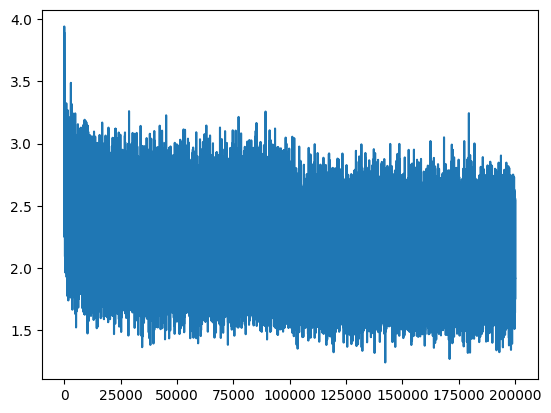

In [6]:
train()


In [7]:
print("Final loss over training set:", calc_loss_for_dataset(X_train, Y_train))
print("Final loss over dev set:", calc_loss_for_dataset(X_dev, Y_dev))

Final loss over training set: 2.088017225265503
Final loss over dev set: 2.14487886428833


In [8]:
def predict(context_str='', num_chars=1000, stop_on_terminator=True, greedy=False):
    """
    Given an optional starting context, predicts next character(s) in the sequence.
    """

    while num_chars > 0:
        context = ([0] * context_size + [stoi[ch] for ch in context_str])[-context_size:]
        X = torch.tensor([context])
        probs = forward(X)
        if greedy:
            next_idx = probs[0].argmax().item()
        else:
            next_idx = torch.multinomial(probs[0], 1, replacement=True, generator=g).item()
        if next_idx == 0 and stop_on_terminator:
            break
        context_str = context_str + itos[next_idx]
        num_chars -= 1
    return context_str

for _ in range(10):
    print(predict(''))


fary
rdyson
safy
brariana
zite
huskleigh
jasgo
rody
kalconna
analexe


In [9]:
for _ in range(10): print(predict('atu'))

atuya
atuwila
atushi
atula
atul
atuel
atubyta
atun
atuchriya
atugraely


In [10]:
a = torch.tensor([1,2,3]).float()
F.softmax(a, dim=0)

tensor([0.0900, 0.2447, 0.6652])